## Paralelismo com GPU

In [1]:
%%writefile maratona.cu

#include <iostream>
#include <thrust/host_vector.h>
#include <thrust/device_vector.h>
#include <thrust/sort.h>
#include <thrust/copy.h>
#include <thrust/iterator/zip_iterator.h>

// STRUCT
struct filme {
    int inicio;
    int fim;
    int categoria;
};

// Struct para organizar os filmes em ordem crescente de fim
struct FilmeCompare {
    __host__ __device__
    bool operator()(const filme& a, const filme& b) {
        if (a.fim != b.fim) {
            return a.fim < b.fim;
        } else {
            return a.inicio < b.inicio;
        }
    }
};

// Struct para evitar filmes que madrugam
struct FilmeLimit {
    __host__ __device__
    bool operator()(const filme& a) {
        int duracao = a.fim - a.inicio;
        return duracao > 0;
    }
};

int main() {
    int n; // Número de filmes
    int m; // Número de categorias totais
    std::cin >> n >> m;

    // ARMAZENAMENTO DE DADOS NA CPU
    thrust::host_vector<filme> filmes_host(n); // armazena filmes do input
    thrust::host_vector<int> max_filmes_host(m); // armazena numero maximo de filmes por categoria
    thrust::host_vector<filme> melhorSelecao_host; // armazenará seleção ótima dos filmes
    int duracaoMaxTotal = 0;

    // INPUTS
    for (int i = 0; i < m; i++) {
        std::cin >> max_filmes_host[i];
    }

    for (int i = 0; i < n; i++) {
        std::cin >> filmes_host[i].inicio >> filmes_host[i].fim >> filmes_host[i].categoria;
    }

    // Transferir dados para a GPU
    thrust::device_vector<filme> filmes_dev = filmes_host;
    thrust::device_vector<int> max_filmes_dev = max_filmes_host;
    thrust::device_vector<filme> melhorSelecao_dev;
    thrust::device_vector<int> duracaoTotal_dev(m, 0);

    // Filtrar os filmes com duração maior que zero (não madrugam)
    thrust::device_vector<filme> filmes_filtrados_dev(n);
    auto filmes_filtrados_end = thrust::copy_if(filmes_dev.begin(), filmes_dev.end(), filmes_filtrados_dev.begin(), FilmeLimit());
    thrust::device_vector<filme> filmes_filtrados(filmes_filtrados_dev.begin(), filmes_filtrados_end);

    // Ordenar filmes por ordem crescente do fim
    thrust::sort(filmes_filtrados.begin(), filmes_filtrados.end(), FilmeCompare());

    // Criar matriz de programação dinâmica
    thrust::device_vector<int> dp((n + 1) * (m + 1), 0);

    // Preencher a matriz com as soluções para subproblemas menores
    for (int i = 1; i <= n; i++) {
        for (int j = 1; j <= m; j++) {
            filme filmeAtual = filmes_dev[i - 1];
            int max_count = 0; // filmes selecionados até o momento
            for (int k = 0; k < i; k++) {
                filme filmeAnterior = filmes_dev[k];
                if (filmeAnterior.categoria == j && filmeAtual.inicio >= filmeAnterior.fim &&
                    dp[(k * (m + 1)) + j - 1] + 1 <= max_filmes_dev[j - 1]) {
                    max_count = max(max_count, dp[(k * (m + 1)) + j - 1] + 1);
                } else {
                    max_count = max(max_count, dp[(k * (m + 1)) + j]);
                }
            }
            dp[(i * (m + 1)) + j] = max_count;
        }
    }

    int duracaoTotal = 0;

    // Reconstruir a seleção ótima
    for (int i = n, j = m; i >= 1 && j >= 1; i--) {
        if (dp[(i * (m + 1)) + j] == dp[((i - 1) * (m + 1)) + j]) {
            continue;
        }
        filme filmeSelecionado = filmes_filtrados[i - 1];
        melhorSelecao_dev.push_back(filmeSelecionado);
        duracaoTotal += filmeSelecionado.fim - filmeSelecionado.inicio;
        duracaoTotal_dev[filmeSelecionado.categoria - 1] += filmeSelecionado.fim - filmeSelecionado.inicio;
        j--;

        // Atualizar a maratona com maior tempo de tela
        if (duracaoTotal > duracaoMaxTotal) {
            duracaoMaxTotal = duracaoTotal;
        }
    }

    // Transferir resultado de volta para a CPU
    melhorSelecao_host = melhorSelecao_dev;
    thrust::host_vector<int> duracaoTotal_host_final = duracaoTotal_dev;

    // OUTPUTS
    std::cout << "Quantidade de filmes da maratona: " << melhorSelecao_host.size() << std::endl;
    std::cout << "Duração total dos filmes selecionados: " << duracaoMaxTotal << std::endl;
    std::cout << "----------" << std::endl;
    std::cout << "Filmes da maratona: " << std::endl;
    for (const auto& filme : melhorSelecao_host) {
        std::cout << filme.inicio << " " << filme.fim << " " << filme.categoria << std::endl;
    }

    return 0;
}



Writing maratona.cu


In [2]:
!nvcc -arch=sm_70 -std=c++14 maratona.cu -o maratona

In [3]:
!./maratona < "input0.txt"

Quantidade de filmes da maratona: 2
Duração total dos filmes selecionados: 5
----------
Filmes da maratona: 
20 23 3
13 15 2


In [ ]:
!./maratona < "input15.txt"

Quantidade de filmes da maratona: 2
Duração total dos filmes selecionados: 7
----------
Filmes da maratona: 
10 14 1
3 6 2


In [4]:
!./maratona < "input25.txt"

Quantidade de filmes da maratona: 3
Duração total dos filmes selecionados: 8
----------
Filmes da maratona: 
8 11 1
7 9 1
4 7 3


In [5]:
!./maratona < "input35.txt"

Quantidade de filmes da maratona: 2
Duração total dos filmes selecionados: 7
----------
Filmes da maratona: 
2 6 1
2 5 1


In [6]:
!./maratona < "input50.txt"

Quantidade de filmes da maratona: 1
Duração total dos filmes selecionados: 2
----------
Filmes da maratona: 
2 4 3


In [8]:
### EXAUSTIVA (para poder fazer a comparação com GPU)
%%writefile exaustiva.cpp

#include <iostream>
#include <vector>
#include <algorithm>
#include <omp.h>

using namespace std;


// STRUCT DO FILME
struct filme {
    int inicio;
    int fim;
    int categoria;
};

// FUNCAO DE ORDENACAO CRESCENTE DO FIM DOS FILMES
bool my_compare(filme a, filme b) {
    if (a.fim != b.fim) {
        return a.fim < b.fim;
    } else {
        return a.inicio < b.inicio;
    }
}

// VERIFICAÇÃO SE DOIS FILMES TEM SOBREPOSIÇÃO DE HORÁRIOS
bool hasOverlap(filme a, filme b) {
    return !(a.fim <= b.inicio || b.fim <= a.inicio);
}

// FUNÇÃO RECURSIVA QUE FAZ A BUSCA EXAUSTIVA
void buscaExaustiva(const vector<filme>& filmes, const vector<int>& max_filmes,
                    vector<filme>& selecaoAtual, vector<int>& cntCat,
                    int bitmask, int pos, int& maxSelecionados, int& duracaoMaxTotal,
                    vector<filme>& melhorSelecao) {

    // VERIFICA SE A BUSCA CHEGOU AO FIM
    if (pos >= filmes.size()) {
        int duracaoAtual = 0;
        for (const auto& filme : selecaoAtual) {
            duracaoAtual += (filme.fim - filme.inicio);
        }
        // VERIFICA SE O NÚMERO DE FILMES SELECIONADOS PARA CADA CATEGORIA NAO EXCEDE O LIMITE ESTABELECIDO POR MAX_FILMES
        bool valido = true;
        for (int i = 0; i < cntCat.size(); i++) {
            if (cntCat[i] > max_filmes[i]) {
                valido = false;
                break;
            }
        }
        // SE A SELEÇÃO ATUAL FOR VÁLIDA E A DURAÇÃO TOTAL FOR MAIOR QUE A DURAÇÃO MÁXIMA ATUAL, ATUALIZA A DURAÇÃO MÁXIMA E O NÚMERO DE FILMES SELECIONADOS
        if (valido && duracaoAtual > duracaoMaxTotal) {
            duracaoMaxTotal = duracaoAtual;
            maxSelecionados = selecaoAtual.size();
            melhorSelecao = selecaoAtual;
        }

        return;
    }

    // CONTINUA A BUSCA SEM SELECIONAR O FILME ATUAL
    buscaExaustiva(filmes, max_filmes, selecaoAtual, cntCat, bitmask, pos + 1,
                    maxSelecionados, duracaoMaxTotal, melhorSelecao);

    // SE O FILME ATUAL NÃO TIVER SIDO SELECIONADO AINDA
    if (!(bitmask & (1 << pos))) {
        bool overlap = false;
        for (const auto& filme : selecaoAtual) {
            if (hasOverlap(filmes[pos], filme)) {
                overlap = true;
                break;
            }
        }
        // E TAMBEM SE NAO TIVER SOBREPOSIÇÃO DE HORÁRIOS COM NENHUM DOS FILMES JÁ SELECIONADOS
        if (!overlap) {
            selecaoAtual.push_back(filmes[pos]);
            cntCat[filmes[pos].categoria - 1]++;
            buscaExaustiva(filmes, max_filmes, selecaoAtual, cntCat, bitmask | (1 << pos),
                            pos + 1, maxSelecionados, duracaoMaxTotal, melhorSelecao);
            selecaoAtual.pop_back(); // filme é removido da seleção atual
            cntCat[filmes[pos].categoria - 1]--; // contador de filmes da categoria é decrementado
        }
    }
}

int main() {
    int n; // Número de filmes
    int m; // Número de categorias totais
    cin >> n >> m;

    vector<filme> filmes(n);
    vector<int> max_filmes(m);
    vector<filme> melhorSelecao;
    vector<int> duracaoTotal(m, 0);

    // INPUTS
    for (int i = 0; i < m; i++) {
        cin >> max_filmes[i];
    }

    for (int i = 0; i < n; i++) {
        cin >> filmes[i].inicio >> filmes[i].fim >> filmes[i].categoria;
    }

    // USO DA FUNÇÃO DE ORDENAÇÃO
    sort(filmes.begin(), filmes.end(), my_compare);

    int maxSelecionados = 0;
    int duracaoMaxTotal = 0;

    vector<filme> selecaoAtual;
    vector<int> cntCat(m, 0);

    buscaExaustiva(filmes, max_filmes, selecaoAtual, cntCat, 0, 0,
                    maxSelecionados, duracaoMaxTotal, melhorSelecao);

    cout << "Quantidade de filmes da maratona: " << maxSelecionados << std::endl;
    cout << "Duração total dos filmes selecionados: " << duracaoMaxTotal << std::endl;
    cout << "----------" << std::endl;
    cout << "Filmes da maratona: " << std::endl;
    for (const auto& filme : melhorSelecao) {
        cout << filme.inicio << " " << filme.fim << " " << filme.categoria << std::endl;
    }

    return 0;
}


Overwriting exaustiva.cpp


In [9]:
!g++ -o exaustiva exaustiva.cpp

## Análise de comparação da Busca Exaustiva com GPU

#### Número de filmes X Tempo de execução

In [3]:
# Import de Bibliotecas
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import time

# Função para cálculo do tempo de execução
def roda_com_entrada(executavel, arquivo_in):
  with open(arquivo_in) as f:
    start = time.perf_counter()
    proc = subprocess.run([executavel], input=f.read(), text=True, capture_output=True)
    end = time.perf_counter()

    stdout = proc.stdout
    

    tempo = end - start
    return (stdout, end - start)

In [10]:
## Arquivos de input
arqs = ['inputs/input0.txt', 'inputs/input15.txt', 'inputs/input25.txt', 'inputs/input35.txt', 'inputs/input50.txt']

## ----- Busca Exaustiva -----

temposExaustiva = [roda_com_entrada('./exaustiva', arq)[1] for arq in arqs]
print("Tempos de execução da Busca Exaustiva em cada input: ")
print(temposExaustiva)
print("-"*30)

## ----- GPU -----------------

temposGPU = [roda_com_entrada('./maratona', arq)[1] for arq in arqs]
print("Tempos de execução da Paralelização com GPU em cada input: ")
print(temposGPU)
print("-"*30)

Tempos de execução da Busca Exaustiva em cada input: 
[0.002753776000020025, 0.00274341499999764, 0.0077020470000093155, 0.17576613699998234, 20.671709215999954]
------------------------------
Tempos de execução da Paralelização com GPU em cada input: 
[0.2010951670000054, 0.11337031700003308, 0.12554924500000197, 0.15916810999999598, 0.2335079819999919]
------------------------------


#### Número de filmes X Tempo de tela

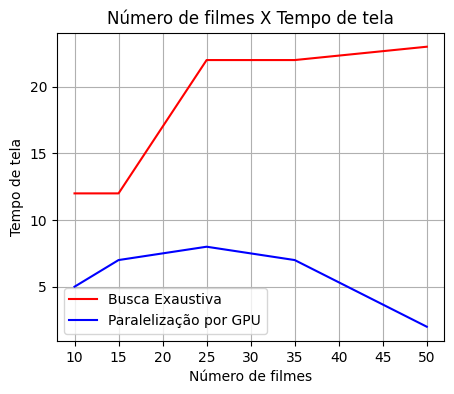

In [11]:
numFilmes = [10, 15, 25, 35, 50]

telaExaustiva = [12, 12, 22, 22, 23]
telaGPU = [5, 7, 8, 7, 2]

plt.figure(figsize=(5,4))
plt.plot(numFilmes, telaExaustiva, color='red', label = "Busca Exaustiva")
plt.plot(numFilmes, telaGPU, color='blue', label = "Paralelização por GPU")
plt.xlabel("Número de filmes")
plt.ylabel("Tempo de tela")
plt.title("Número de filmes X Tempo de tela")
plt.grid()
plt.legend()
plt.show()